# Presidential compaign donation committees can choose to be Monthly or Quarterly FEC filers.
## ActBlue, the Democratic digital committee is a quarterly filer, so we won't get their data until their report date of April 15, 2019

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import janitor
import geopandas as gpd
import geoplot
from sklearn import preprocessing
import geoplot.crs as gcrs

pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:,.2f}'.format
sns.set()

%matplotlib inline

In [13]:
with open('cn_header_file.csv', 'r') as f:
    cn_columns = f.read().strip().split(',')
cn_columns

['CAND_ID',
 'CAND_NAME',
 'CAND_PTY_AFFILIATION',
 'CAND_ELECTION_YR',
 'CAND_OFFICE_ST',
 'CAND_OFFICE',
 'CAND_OFFICE_DISTRICT',
 'CAND_ICI',
 'CAND_STATUS',
 'CAND_PCC',
 'CAND_ST1',
 'CAND_ST2',
 'CAND_CITY',
 'CAND_ST',
 'CAND_ZIP']

In [14]:
candidate_master = pd.read_csv('2020/cn.txt', sep='|', names=cn_columns)
candidate_master = janitor.clean_names(candidate_master)

In [15]:
# clean up data and optimize dtypes
candidate_master['cand_office'] = candidate_master['cand_office'].astype('category')
candidate_master['cand_election_yr'] = candidate_master['cand_election_yr'].astype(np.int16)
candidate_master['cand_zip'] = candidate_master['cand_zip'].apply(lambda x: x // 10000 if x > 99999 else x)
candidate_master['cand_zip'].fillna(99999, inplace=True)
candidate_master['cand_zip'] = candidate_master['cand_zip'].astype(np.int32)

In [16]:
pres_candidates = candidate_master[(candidate_master['cand_election_yr']==2020) & (candidate_master['cand_office']=='P')]

In [17]:
with open('ccl_header_file.csv', 'r') as f:
    ccl_columns = f.read().strip().split(',')
ccl_columns

['CAND_ID',
 'CAND_ELECTION_YR',
 'FEC_ELECTION_YR',
 'CMTE_ID',
 'CMTE_TP',
 'CMTE_DSGN',
 'LINKAGE_ID']

In [18]:
cand_com_linkage = pd.read_csv('2020/ccl.txt', sep='|', names=ccl_columns)
cand_com_linkage = janitor.clean_names(cand_com_linkage)

In [19]:
a = pres_candidates.merge(cand_com_linkage)
a[a['cand_name'].str.contains('TRUMP')]

,cand_id,cand_name,cand_pty_affiliation,cand_election_yr,cand_office_st,cand_office,cand_office_district,cand_ici,cand_status,cand_pcc,cand_st1,cand_st2,cand_city,cand_st,cand_zip,fec_election_yr,cmte_id,cmte_tp,cmte_dsgn,linkage_id
347,P80001571,"TRUMP, DONALD J",REP,2020,US,P,0.00,I,C,C00580100,725 FIFTH AVENUE,NaN,NEW YORK,NY,10022,2020,C00621672,N,U,224958
348,P80001571,"TRUMP, DONALD J",REP,2020,US,P,0.00,I,C,C00580100,725 FIFTH AVENUE,NaN,NEW YORK,NY,10022,2020,C00580100,P,P,222901


# Individual contributions to committees

In [255]:
with open('indiv_header_file.csv', 'r') as f:
    indiv_columns = f.read().strip().split(',')
indiv_contribution = pd.read_csv('2020/itcont.txt', sep='|', names=indiv_columns, parse_dates=['TRANSACTION_DT'])
indiv_contribution = janitor.clean_names(indiv_contribution)
indiv_contribution['transaction_dt'] = pd.to_datetime(indiv_contribution['transaction_dt'], format='%m%d%Y', errors='coerce')
indiv_contribution['image_num_dt'] = pd.to_datetime(indiv_contribution['image_num'] // 10000000000, format='%Y%m%d', errors='coerce')
indiv_contribution['employer'] = indiv_contribution['employer'].fillna('N/A')

In [256]:
indiv_contribution.head()

,cmte_id,amndt_ind,rpt_tp,transaction_pgi,image_num,transaction_tp,entity_tp,name,city,state,zip_code,employer,occupation,transaction_dt,transaction_amt,other_id,tran_id,file_num,memo_cd,memo_text,sub_id,image_num_dt
0,C00432906,T,TER,P,201901219143901218,22Y,IND,"LEMUNYON, GLENN",WASHINGTON,DC,20002,N/A,NaN,2019-01-18,500,NaN,SB20A.55756,1305860,NaN,NaN,4021320191639407455,2019-01-21
1,C00432906,T,TER,P,201901219143901218,22Y,IND,"LEMUNYON, GLENN",WASHINGTON,DC,20002,N/A,NaN,2019-01-18,-500,NaN,SB20A.55755,1305860,NaN,NaN,4021320191639407453,2019-01-21
2,C00638478,T,TER,P,201901289144040159,15C,CAN,"JANOWICZ, PHILIP",BUENA PARK,CA,906211685,FRIENDS OF PHIL JANOWICZ,CANDIDATE,2019-01-28,35000,H8CA39133,3703295,1307800,NaN,CONVERTING PRIMARY LOAN TO CONTRIBUTION,4021220191639267648,2019-01-28
3,C00638478,T,TER,P,201901289144040158,15,IND,"STEVENS, RICHARD",DIAMOND BAR,CA,917653902,NOT EMPLOYED,NOT EMPLOYED,2019-01-25,-50,NaN,3703278,1307800,NaN,CHECK LOST,4021220191639267645,2019-01-28
4,C00638478,T,TER,P,201901289144040159,15C,CAN,"JANOWICZ, PHILIP",BUENA PARK,CA,906211685,FRIENDS OF PHIL JANOWICZ,CANDIDATE,2019-01-28,59816,H8CA39133,3703293,1307800,NaN,CONVERTING PRIMARY LOAN TO CONTRIBUTION,4021220191639267646,2019-01-28


In [266]:
# People from Pru who donated to a PAC
indiv_contribution[indiv_contribution['employer'].str.contains('prudential financial', case=False)]['cmte_id'].unique()

array(['C00127779', 'C00493304'], dtype=object)

In [103]:
indiv_contribution['transaction_dt'].max()

Timestamp('2019-03-04 00:00:00')

In [68]:
indiv_cont_cmte = indiv_contribution.groupby('cmte_id').agg({'transaction_amt': np.sum})

In [75]:
a.merge(indiv_cont_cmte, left_on='cmte_id', right_index=True)

,cand_id,cand_name,cand_pty_affiliation,cand_election_yr,cand_office_st,cand_office,cand_office_district,cand_ici,cand_status,cand_pcc,cand_st1,cand_st2,cand_city,cand_st,cand_zip,fec_election_yr,cmte_id,cmte_tp,cmte_dsgn,linkage_id,transaction_amt


In [92]:
indiv_contribution[indiv_contribution['cmte_id'] == 'C00577130']

,cmte_id,amndt_ind,rpt_tp,transaction_pgi,image_num,transaction_tp,entity_tp,name,city,state,zip_code,employer,occupation,transaction_dt,transaction_amt,other_id,tran_id,file_num,memo_cd,memo_text,sub_id


# Committee contribution to Candidate and expenditures

In [222]:
with open('pas2_header_file.csv', 'r') as f:
    pas2_columns = f.read().strip().split(',')

cm_contribution_cn = pd.read_csv('2020/itpas2.txt', sep='|', names=pas2_columns,  parse_dates=['TRANSACTION_DT'])
cm_contribution_cn = janitor.clean_names(cm_contribution_cn)
cm_contribution_cn['transaction_dt'] = pd.to_datetime(cm_contribution_cn['transaction_dt'], format='%m%d%Y', errors='coerce')
cm_contribution_cn['image_num_dt'] = pd.to_datetime(cm_contribution_cn['image_num'] // 10000000000, format='%Y%m%d', errors='coerce')

In [109]:
cm_contribution_cn.head()

,cmte_id,amndt_ind,rpt_tp,transaction_pgi,image_num,transaction_tp,entity_tp,name,city,state,zip_code,employer,occupation,transaction_dt,transaction_amt,other_id,cand_id,tran_id,file_num,memo_cd,memo_text,sub_id,image_num_dt
0,C00567180,T,TER,P,201901099143774199,24K,PAC,TED YOHO FOR CONGRESS,GAINESVILLE,FL,"32,608.00",nan,nan,2019-01-18,1880,C00494583,H2FL06109,SB23.4447,1303604,NaN,NaN,4021920191640423011,2019-01-21
1,C00104885,A,TER,G,201901289144031511,24K,CCM,TEAM GRAHAM INC,COLUMBIA,SC,"29,202.00",nan,nan,2019-01-18,3000,C00458828,H4SC03087,SB23.17757,1307636,NaN,NaN,4022220191643444985,2019-01-21
2,C00104885,A,TER,P,201901289144031512,24K,CCM,TIM SCOTT FOR SENATE,CHARLESTON,SC,"29,407.00",nan,nan,2019-01-28,1000,C00540302,H0SC01279,SB23.17756,1307636,NaN,NaN,4022220191643444987,2019-01-28
3,C00104885,A,TER,P,201901289144031511,24K,CCM,FRIENDS OF JIM CLYBURN,COLUMBIA,SC,"29,211.00",nan,nan,2019-01-25,470,C00255562,H2SC02042,SB23.17755,1307636,NaN,NaN,4022220191643444981,2019-01-28
4,C00688408,T,TER,G,201901319144305867,24E,ORG,JACKSON ADVOCATE,JACKSON,MS,"39,207.00",nan,nan,2019-01-28,1000,S8MS00287,S8MS00287,SE.4233,1310906,NaN,NaN,4022420191643632157,2019-01-28


In [260]:
cm_contribution_cn[cm_contribution_cn['cmte_id']=='C00127779']

,cmte_id,amndt_ind,rpt_tp,transaction_pgi,image_num,transaction_tp,entity_tp,name,city,state,zip_code,employer,occupation,transaction_dt,transaction_amt,other_id,cand_id,tran_id,file_num,memo_cd,memo_text,sub_id,image_num_dt


In [111]:
cm_contribution_cn[cm_contribution_cn['cand_id']=='P80001571'].head()

,cmte_id,amndt_ind,rpt_tp,transaction_pgi,image_num,transaction_tp,entity_tp,name,city,state,zip_code,employer,occupation,transaction_dt,transaction_amt,other_id,cand_id,tran_id,file_num,memo_cd,memo_text,sub_id,image_num_dt
1347,C00587022,N,M2,P,201902209145546643,24E,ORG,ATLANTIC MEDIA,RODANTHE,NC,"27,968.00",nan,nan,2019-01-24,11441,P80001571,P80001571,SE.5716,1317111,NaN,NaN,4022420191643632288,2019-02-12
1373,C00608489,N,M2,G,201902209145546755,24E,ORG,RIGHT COUNTRY LISTS,ALEXANDRIA,VA,"22,314.00",nan,nan,2019-01-04,1000,P80001571,P80001571,SE24.149575,1317113,X,NaN,4022520191643639406,2019-02-12
1374,C00608489,N,M2,G,201902209145546754,24E,ORG,CAMPAIGN SOLUTIONS,ALEXANDRIA,VA,"22,314.00",nan,nan,2019-01-09,20000,P80001571,P80001571,SE24.149568,1317113,X,NaN,4022520191643639400,2019-02-12
1375,C00608489,N,M2,G,201902209145546754,24E,ORG,CONNELL DONATELLI INC.,ALEXANDRIA,VA,"22,314.00",nan,nan,2019-01-10,2000,P80001571,P80001571,SE24.149571,1317113,X,NaN,4022520191643639402,2019-02-12
1376,C00608489,N,M2,G,201902209145546755,24E,ORG,POLITICAL LIST BROKERS LLC,ALEXANDRIA,VA,"22,314.00",nan,nan,2019-01-09,10000,P80001571,P80001571,SE24.149574,1317113,X,NaN,4022520191643639404,2019-02-12


# Committee Master File

In [220]:
with open('cm_header_file.csv', 'r') as f:
    cm_master_columns = f.read().strip().split(',')

cm_master = pd.read_csv('2020/cm.txt', sep='|', names=cm_master_columns)
cm_master = janitor.clean_names(cm_master)

In [259]:
cm_master[cm_master['cmte_id']=='C00127779']

,cmte_id,cmte_nm,tres_nm,cmte_st1,cmte_st2,cmte_city,cmte_st,cmte_zip,cmte_dsgn,cmte_tp,cmte_pty_affiliation,cmte_filing_freq,org_tp,connected_org_nm,cand_id
663,C00127779,PRUDENTIAL FINANCIAL INC. FEDERAL POLITICAL AC...,"GABRIEL, ROMAN MR.",751 BROAD STREET,14TH FLOOR,NEWARK,NJ,071023777,B,Q,NaN,M,C,"PRUDENTIAL FINANCIAL, INC.",NaN


In [267]:
cm_master[cm_master['cmte_id']=='C00493304']

,cmte_id,cmte_nm,tres_nm,cmte_st1,cmte_st2,cmte_city,cmte_st,cmte_zip,cmte_dsgn,cmte_tp,cmte_pty_affiliation,cmte_filing_freq,org_tp,connected_org_nm,cand_id
4027,C00493304,PRUDENTIAL FINANCIAL INC STATE AND FEDERAL POL...,"GABRIEL, ROMAN MR",751 BROAD STREET,14TH FLOOR,NEWARK,NJ,07102,U,Q,NaN,M,C,NaN,NaN


In [268]:
cm_master[cm_master['cmte_nm'].str.contains('prudential', case=False)]

,cmte_id,cmte_nm,tres_nm,cmte_st1,cmte_st2,cmte_city,cmte_st,cmte_zip,cmte_dsgn,cmte_tp,cmte_pty_affiliation,cmte_filing_freq,org_tp,connected_org_nm,cand_id
663,C00127779,PRUDENTIAL FINANCIAL INC. FEDERAL POLITICAL AC...,"GABRIEL, ROMAN MR.",751 BROAD STREET,14TH FLOOR,NEWARK,NJ,071023777,B,Q,NaN,M,C,"PRUDENTIAL FINANCIAL, INC.",NaN
4027,C00493304,PRUDENTIAL FINANCIAL INC STATE AND FEDERAL POL...,"GABRIEL, ROMAN MR",751 BROAD STREET,14TH FLOOR,NEWARK,NJ,07102,U,Q,NaN,M,C,NaN,NaN


In [221]:
cm_master.merge(indiv_cont_cmte, left_on='cmte_id', right_index=True).sort_values(by='transaction_amt', ascending=False).head()

NameError: name 'indiv_cont_cmte' is not defined

In [112]:
cm_master.head()

,cmte_id,cmte_nm,tres_nm,cmte_st1,cmte_st2,cmte_city,cmte_st,cmte_zip,cmte_dsgn,cmte_tp,cmte_pty_affiliation,cmte_filing_freq,org_tp,connected_org_nm,cand_id
0,C00000059,HALLMARK CARDS PAC,SARAH MOE,2501 MCGEE,MD #500,KANSAS CITY,MO,64108,U,Q,UNK,M,C,NaN,NaN
1,C00000422,AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION ...,"WALKER, KEVIN MR.","25 MASSACHUSETTS AVE, NW",SUITE 600,WASHINGTON,DC,200017400,B,Q,NaN,M,M,DELAWARE MEDICAL PAC,NaN
2,C00000489,D R I V E POLITICAL FUND CHAPTER 886,TOM RITTER,3528 W RENO,NaN,OKLAHOMA CITY,OK,73107,U,N,NaN,Q,L,TEAMSTERS LOCAL UNION 886,NaN
3,C00000547,KANSAS MEDICAL SOCIETY POLITICAL ACTION COMMITTEE,JERRY SLAUGHTER,623 SW 10TH AVE,NaN,TOPEKA,KS,666121627,U,Q,UNK,Q,M,KANSAS MEDICAL SOCIETY,NaN
4,C00000638,INDIANA STATE MEDICAL ASSOCIATION POLITICAL AC...,"ACHENBACH, GRANT MR.","322 CANAL WALK, CANAL LEVEL",NaN,INDIANAPOLIS,IN,46202,U,Q,NaN,Q,M,INDIANA STATE MEDICAL ASSOCIATION,NaN


In [196]:
with open('webk_headers.csv', 'r') as f:
    webk_columns = f.read().strip().split(',')

webk20 = pd.read_csv('2020/webk20.txt', sep='|', names=webk_columns)
webk20 = janitor.clean_names(webk20)

In [218]:
webk20.sort_values(by='ttl_receipts', ascending=False).head()

,cmte_id,cmte_nm,cmte_tp,cmte_dsgn,cmte_filing_freq,ttl_receipts,trans_from_aff,indv_contrib,other_pol_cmte_contrib,cand_contrib,cand_loans,ttl_loans_received,ttl_disb,tranf_to_aff,indv_refunds,other_pol_cmte_refunds,cand_loan_repay,loan_repay,coh_bop,coh_cop,debts_owed_by,nonfed_trans_received,contrib_to_other_cmte,ind_exp,pty_coord_exp,nonfed_share_exp,cvg_end_dt
40,C00003418,REPUBLICAN NATIONAL COMMITTEE,Y,U,M,"15,659,229.55","6,657,172.22","8,894,679.50",0.00,0.00,0.00,0.00,"10,588,506.44","42,260.00","25,547.00",0.00,0.00,0.00,"23,501,561.43","28,572,284.54",0.00,0.00,0.00,0.00,48.00,0.00,01/31/2019
8,C00000935,DCCC,Y,U,M,"7,288,899.01","179,100.00","4,971,615.42","1,932,795.00",0.00,0.00,0.00,"6,012,715.61",0.00,"99,116.18",0.00,0.00,"2,000,000.00","5,615,495.89","6,891,679.29","15,865,930.22",0.00,0.00,0.00,0.00,0.00,01/31/2019
119,C00010603,DNC SERVICES CORP./DEM. NAT'L COMMITTEE,Y,U,M,"6,540,886.48",0.00,"4,375,600.83","60,000.00",0.00,0.00,0.00,"8,577,669.34","631,118.20","31,283.93",0.00,0.00,0.00,"8,550,790.77","6,514,007.91","5,659,586.36",0.00,0.00,0.00,0.00,0.00,01/31/2019
200,C00027466,NRSC,Y,U,M,"5,578,720.31","844,673.42","2,861,779.14","934,586.00",0.00,0.00,0.00,"5,487,179.53",0.00,"116,249.51",0.00,0.00,"3,000,000.00","7,497,935.78","7,589,476.56","14,000,000.00",0.00,0.00,0.00,0.00,0.00,01/31/2019
375,C00075820,NRCC,Y,U,M,"5,112,412.05","293,213.18","2,452,262.29","1,757,500.00",0.00,0.00,0.00,"5,470,537.61",0.00,"74,584.12",0.00,0.00,"2,000,000.00","16,565,197.57","16,207,072.01","8,600,000.00",0.00,0.00,0.00,0.00,0.00,01/31/2019


# Committees Transfers to Other Committees

In [269]:
with open('oth_header_file.csv', 'r') as f:
    oth_columns = f.read().strip().split(',')

oth20 = pd.read_csv('2020/itoth.txt', sep='|', names=oth_columns,  parse_dates=['TRANSACTION_DT'])
oth20 = janitor.clean_names(cm_contribution_cn)
oth20['transaction_dt'] = pd.to_datetime(oth20['transaction_dt'], format='%m%d%Y', errors='coerce')
oth20['image_num_dt'] = pd.to_datetime(oth20['image_num'] // 10000000000, format='%Y%m%d', errors='coerce')

In [273]:
oth20

,cmte_id,amndt_ind,rpt_tp,transaction_pgi,image_num,transaction_tp,entity_tp,name,city,state,zip_code,employer,occupation,transaction_dt,transaction_amt,other_id,cand_id,tran_id,file_num,memo_cd,memo_text,sub_id,image_num_dt
0,C00567180,T,TER,P,201901099143774199,24K,PAC,TED YOHO FOR CONGRESS,GAINESVILLE,FL,"32,608.00",nan,nan,2019-01-08,1880,C00494583,H2FL06109,SB23.4447,1303604,NaN,NaN,4021920191640423011,2019-01-09
1,C00104885,A,TER,G,201901289144031511,24K,CCM,TEAM GRAHAM INC,COLUMBIA,SC,"29,202.00",nan,nan,2018-12-20,3000,C00458828,H4SC03087,SB23.17757,1307636,NaN,NaN,4022220191643444985,2019-01-28
2,C00104885,A,TER,P,201901289144031512,24K,CCM,TIM SCOTT FOR SENATE,CHARLESTON,SC,"29,407.00",nan,nan,2018-12-20,1000,C00540302,H0SC01279,SB23.17756,1307636,NaN,NaN,4022220191643444987,2019-01-28
3,C00104885,A,TER,P,201901289144031511,24K,CCM,FRIENDS OF JIM CLYBURN,COLUMBIA,SC,"29,211.00",nan,nan,2019-01-07,470,C00255562,H2SC02042,SB23.17755,1307636,NaN,NaN,4022220191643444981,2019-01-28
4,C00688408,T,TER,G,201901319144305867,24E,ORG,JACKSON ADVOCATE,JACKSON,MS,"39,207.00",nan,nan,2018-12-12,1000,S8MS00287,S8MS00287,SE.4233,1310906,NaN,NaN,4022420191643632157,2019-01-31
5,C00414425,N,M2,P,201902019145450791,24K,CCM,FRIENDS OF MARK WARNER,ALEXANDRIA,VA,"22,314.00",nan,nan,2019-01-29,1000,C00438713,S6VA00093,SB23.9011,1313349,NaN,NaN,4022620191643762178,2019-02-01
6,C00325324,N,M2,P,201902049145458880,24K,CCM,EMMER FOR CONGRESS,ANOKA,MN,"55,303.00",nan,nan,2019-01-25,1500,C00545749,H4MN06087,B27CCDF382AE3419EB12,1313984,NaN,NaN,4022620191643762236,2019-02-04
7,C00366013,N,M2,P,201902049145460163,24K,CCM,CLAY JR. FOR CONGRESS,SAINT LOUIS,MO,"631,080,544.00",nan,nan,2019-01-10,1000,C00346080,H0MO01066,BCC5E5592BA664439810,1314222,NaN,NaN,4022620191643761316,2019-02-04
8,C00366013,N,M2,P,201902049145460162,24K,CCM,MALONEY FOR CONGRESS,NEW YORK,NY,"101,281,326.00",nan,nan,2019-01-02,2500,C00273169,H2NY14037,BE5946F36B95C4B1AA76,1314222,NaN,NaN,4022620191643761310,2019-02-04
9,C00366013,N,M2,P,201902049145460162,24K,CCM,MCHENRY FOR CONGRESS,GASTONIA,NC,"280,532,165.00",nan,nan,2019-01-10,1000,C00393629,H4NC10047,B4A12FABC952A45BFAA6,1314222,NaN,NaN,4022620191643761312,2019-02-04


# Trying to Map things

In [65]:
zip_map = gpd.read_file('zip://cb_2017_us_zcta510_500k.zip')
state_map = gpd.read_file('zip://tl_2018_us_state.zip')
#map_df = map_df.cx[:-50, 0:]

In [61]:
map_df.head()

,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry
0,35442,8600000US35442,35442,610213891,10838694,"(POLYGON ((-88.252618 32.92675, -88.249724 32...."
1,85365,8600000US85365,85365,3545016067,9766486,"(POLYGON ((-114.684663 32.687389, -114.676063 ..."
2,71973,8600000US71973,71973,204670474,1264709,"POLYGON ((-94.46643176650841 34.330735, -94.46..."
3,95445,8600000US95445,95445,221559097,7363179,"POLYGON ((-123.643051 38.851233, -123.641401 3..."
4,06870,8600000US06870,06870,5945321,3841130,"POLYGON ((-73.58765810889219 41.0076522198727,..."


In [39]:
len(map_df['ZCTA5CE10'])# - map_df['ZCTA5CE10'].nunique()

33144

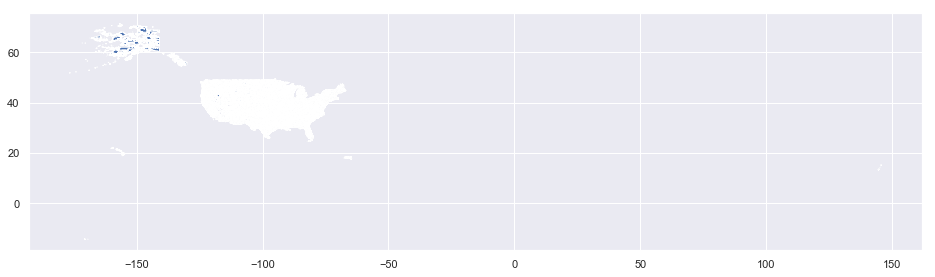

In [7]:
map_df.plot(figsize=(16,10))

In [41]:
ic_clean = indiv_contribution.dropna(subset=['zip_code'])
ic_clean = ic_clean[ic_clean['zip_code'].str.isnumeric()]
ic_clean['zip_code'] = ic_clean.apply(lambda row: row['zip_code'][:5], axis=1)
ic_grouped = ic_clean.groupby('zip_code').agg({'transaction_amt': 'sum'})

In [99]:
map_merged = zip_map2.merge(ic_grouped, left_on='GEOID10', right_index=True, how='left')
map_merged['transaction_amt'].fillna(0, inplace=True)
#map_merged.plot(column='transaction_amt', figsize=(16,10))

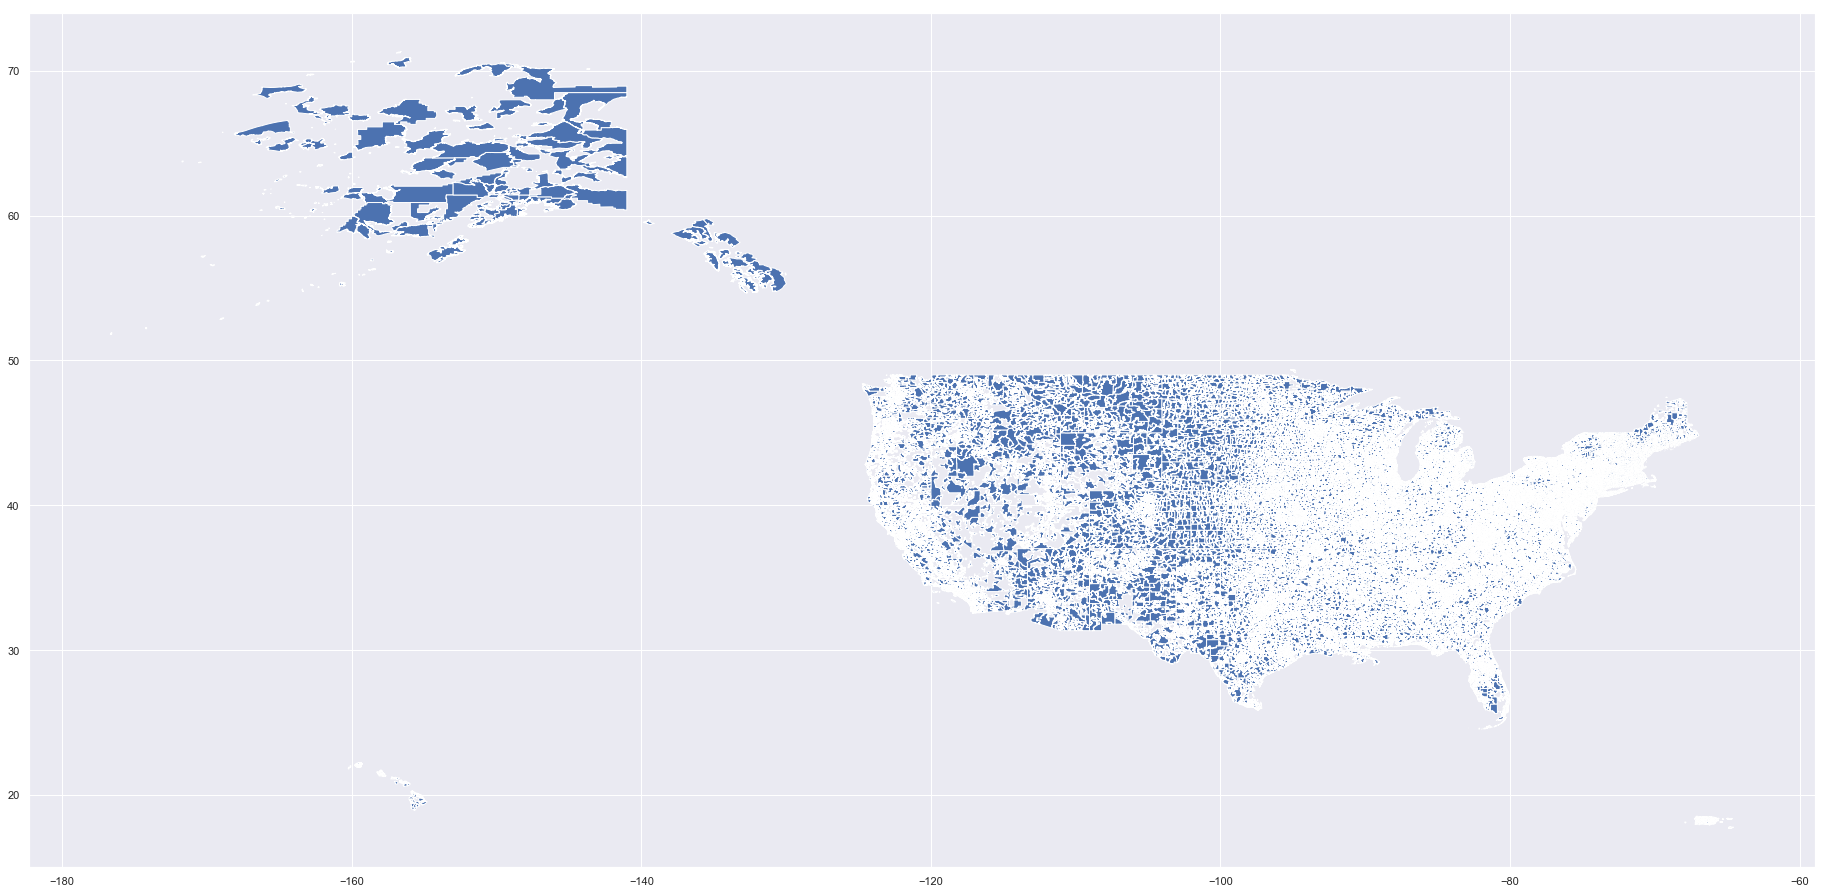

In [72]:
zip_map2['geometry'].plot(figsize=(32,20));

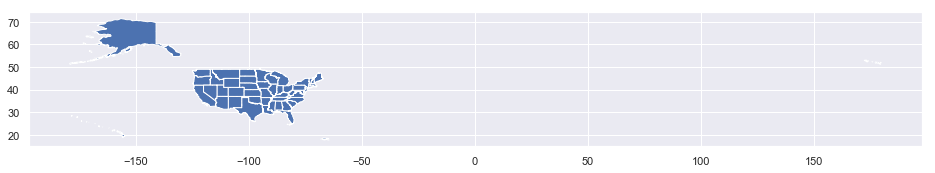

In [75]:
state_map2.plot(figsize=(16,10));

In [85]:
print(state_map2.cx[-50:,:]['geometry'])

40    (POLYGON ((-165.254162 60.917108, -165.263026 ...
Name: geometry, dtype: object


In [74]:
#map_df = map_df.cx[:-50, 0:]
zip_map2 = zip_map.cx[:-50, 0:]
state_map2 = state_map.cx[:-50, 0:]

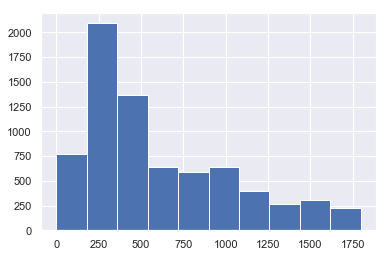

In [167]:
standard_scaler = preprocessing.StandardScaler()
#map_merged['transaction_amt_scaled'] = min_max_scaler.fit_transform(map_merged['transaction_amt'])
x = map_merged[(map_merged['transaction_amt']>0) & (map_merged['transaction_amt']<1800)]['transaction_amt'].values.astype(float).reshape(-1, 1)
x_scaled = standard_scaler.fit_transform(x)
df_normalized = pd.DataFrame(x_scaled)
map_merged[(map_merged['transaction_amt']>0) & (map_merged['transaction_amt']<1800)]['transaction_amt'].hist()

In [136]:
map_merged['transaction_amt']

0            0.00
1        1,350.00
2            0.00
3          400.00
4          500.00
5            0.00
6        2,259.00
7       16,100.00
8            0.00
9          835.00
10           0.00
11           0.00
12         800.00
13           0.00
14           0.00
15         200.00
16       1,960.00
17           0.00
18           0.00
19           0.00
20         518.00
21           0.00
22         210.00
23           0.00
24           0.00
25         703.00
26           0.00
27       1,375.00
28           0.00
29           0.00
           ...   
33114        0.00
33115        0.00
33116        0.00
33117        0.00
33118      213.00
33119        0.00
33120    1,700.00
33121        0.00
33122        0.00
33123        0.00
33124        0.00
33125    1,425.00
33126        0.00
33127        0.00
33128       75.00
33129        0.00
33130        0.00
33131      500.00
33132        0.00
33133      250.00
33134        0.00
33135        0.00
33136        0.00
33137      400.00
33138     

In [109]:
map_merged.sort_values(by='transaction_amt', ascending=False)

,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry,transaction_amt
7050,04101,8600000US04101,04101,5190553,2335813,"POLYGON ((-70.284471 43.670823, -70.277671 43....","872,841.00"
12543,98112,8600000US98112,98112,8185290,3829371,"POLYGON ((-122.317856 47.630487, -122.316509 4...","410,690.00"
31126,10017,8600000US10017,10017,820952,0,"POLYGON ((-73.98088799999999 40.753481, -73.98...","342,603.00"
29811,32963,8600000US32963,32963,44966618,60598455,"POLYGON ((-80.47864199999999 27.854615, -80.45...","287,042.00"
30657,60614,8600000US60614,60614,8079992,864324,"(POLYGON ((-87.67770399999999 41.920042, -87.6...","272,798.00"
30074,11937,8600000US11937,11937,111093086,63976820,"(POLYGON ((-72.142929 41.097811, -72.140737 41...","256,935.00"
4774,33301,8600000US33301,33301,6440076,327063,"POLYGON ((-80.14645 26.122183, -80.145866 26.1...","252,953.00"
831,10023,8600000US10023,10023,1268944,0,"POLYGON ((-73.98877399999999 40.776673, -73.98...","226,386.00"
9207,60606,8600000US60606,60606,569721,92503,"POLYGON ((-87.641378 41.888632, -87.6399759999...","224,431.00"
7897,90071,8600000US90071,90071,319156,0,"POLYGON ((-118.25881 34.052816, -118.255897 34...","222,836.00"


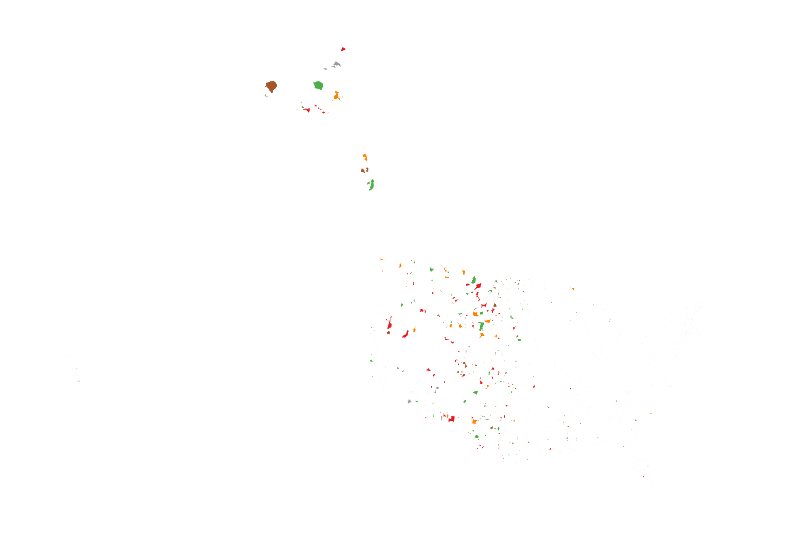

In [171]:
#base = state_map2.plot(color='#FFD700')
#map_merged[['geometry', 'transaction_amt']].plot(cmap='reds', column='transaction_amt', figsize=(32,20))
geoplot.choropleth(map_merged[(map_merged['transaction_amt']>0) & (map_merged['transaction_amt']<1800)], projection=gcrs.AlbersEqualArea(), hue='transaction_amt', scheme='fisher_jenks', figsize=(16, 10))

In [103]:
from shapely.geometry import Polygon, mapping
sh_polygon = state_map2.cx[-50:,:]['geometry']
#mapping(sh_polygon)

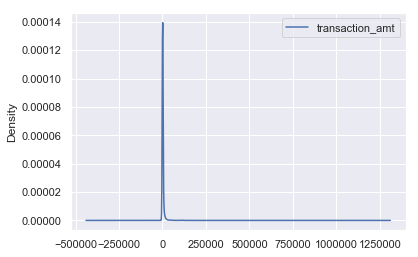

In [126]:
ic_grouped.sort_values(by='transaction_amt', ascending=False).plot.kde()

In [119]:
ic_grouped.sort_values(by='transaction_amt', ascending=False).describe()

,transaction_amt
count,"10,644.00"
mean,"2,959.22"
std,"14,791.43"
min,"-2,500.00"
25%,300.00
50%,716.00
75%,"1,889.25"
max,"872,841.00"


In [123]:
np.median(ic_grouped)

716.0

# Operating Expenditures

In [228]:
with open('oppexp_header_file.csv', 'r') as f:
    oppexp_columns = f.read().strip().split(',')
oppexp_columns.append('dummy') # adding a dummy column as the number of header columns (25) do not match the data columns (26)
oppexp20 = pd.read_csv('2020/oppexp.txt', sep='|', names=oppexp_columns,  parse_dates=['TRANSACTION_DT']).drop('dummy', axis=1)
oppexp20 = janitor.clean_names(oppexp20)
oppexp20['transaction_dt'] = pd.to_datetime(oppexp20['transaction_dt'], format='%m/%d/%Y', errors='coerce')
oppexp20['image_num_dt'] = pd.to_datetime(oppexp20['image_num'] // 10000000000, format='%Y%m%d', errors='coerce')

In [241]:
oppexp_with_cm_names = oppexp20.merge(cm_master[['cmte_id', 'cmte_nm']], on='cmte_id')

In [243]:
oppexp_with_cm_names.groupby(['cmte_nm', 'purpose']).agg({'transaction_amt': 'sum'}).sort_values(by=['transaction_amt', 'cmte_nm'], ascending=False).head(10)

transaction_amt
cmte_nm                                 purpose                                  
REPUBLICAN NATIONAL COMMITTEE           POSTAGE                      1,751,615.58
                                        DATA SERVICES                1,341,465.34
DNC SERVICES CORP./DEM. NAT'L COMMITTEE DIRECT MAIL                  1,322,714.86
REPUBLICAN NATIONAL COMMITTEE           PAYROLL                      1,256,371.21
                                        MAIL PRODUCTION SERVICES     1,233,387.60
                                        TELEMARKETING                1,120,045.91
DNC SERVICES CORP./DEM. NAT'L COMMITTEE DATA SERVICE                 1,042,119.31
                                        PAYROLL                      1,037,940.67
                                        CREDIT CARD PAYMENT          1,013,149.46
NRSC                                    ONLINE PROCESSING FEE          959,285.29

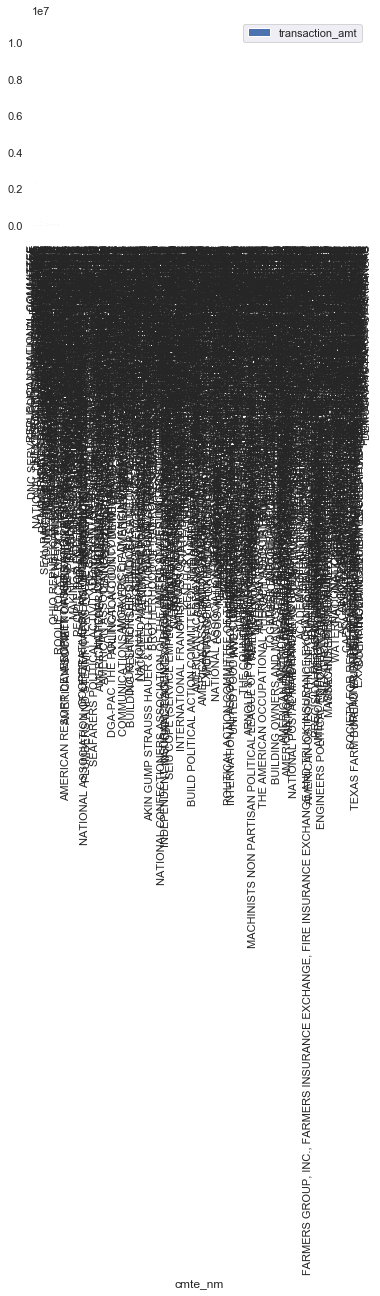

In [250]:
oppexp_with_cm_names.groupby(['cmte_nm']).agg({'transaction_amt':'sum'}).sort_values(by='transaction_amt', ascending=False).plot(kind='bar')